## Variability Time Sampling

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'sims'

### Categorizing variability according to timescale ###

We group all types of galactic stellar variabililty into either transient and periodic phenomena, and consider four very broad categories based on the characteristic *timescale of variability* $\tau_{var}$, since this is the key characteristic affected by changes in lightcurve time sampling when more or fewer visits to a given pointing are made in the course of the survey.  
For transient phenomena, the timescale of variability refers to typical duration of the transient signal, such as the duration of an outburst or explosion, or the Einstein crossing timescale in microlensing.  
For periodic phenomena, the timescale of variability is considered to be the primary periodicity of the object, typically the rotation or orbital period.  

Galactic variability can then be grouped into the following categories according to $\tau_{var}$:
* $<$10 days: including exoplanet & White Dwarf transits, stellar flares, short period stellar binaries, pulsating stars (inc. RR Lyrae, Cepheids), some point-source microlensing (e.g., by free-floating planets, bound planet anomalies, brown dwarfs), most binary microlensing, variability in young stars, short-term accretion variability
* 10-100 days: includes point-source microlensing by galactic stellar-mass lenses (but not binary-lens anomalies), intermediate stellar pulsation periods, disk instability in Cataclysmic Variables, novae
* 100-365 days: includes microlensing by black holes, long-timescale pulsations, 
* $>$365 days: includes long-period variables, e.g. Miras

Although LSST will generate an alert whenever an object varies by more than 5$\sigma$ from the reference flux, for most of Galactic science this is insufficient to reliably detect variability and certainly inadequate to meaningfully classify it.  

Based on previous follow-up experience we require a minimum of 5 observations taken within $\tau_{var}$ to consider a variable target "detectable" in the sense of being able to accurately extract targets of interest from the LSST datastream (for comparison we understand the ZTF estimate that 10 observations are required).  Note that this neglects requirements for multi-color observations in order to simplify the problem.  

Applying this requirement to transient phenomena, we derive a maximum-useful observation interval, $\tau_{obs} = \tau_{var} / 5$ for the four categories above:
* $\tau_{var} < $10 days, $\tau_{obs}$ = 2days
* 10 $<$ $\tau_{var} < $100 days, $\tau_{obs}$ = 2 - 20 days
* 100 $<$ $\tau_{var} < $365 days, $\tau_{obs}$ = 20 - 73 days
* $\tau_{var} > $365 days, $\tau_{obs}$ = 73days

In [5]:
# Maximum acceptable gap in sequential observations for different variability categories [days]:
tau_obs = tau_obs = [2.0, 20.0, 73.0, 365.0]

### Metrics to evaluate time sampling for stellar variability

The gaps in timeseries photometry dictate how well any form of variability can be recovered from it, with the emphasis on minimizing the gaps.  From an observing strategy perspective, aside from the unavoidable daytime gaps, there are three factors which cause gaps: 

* the median interval between sequential observations
* the total period where this median interval is maintained 
* the maximum interval.  This takes into account the potential for longer breaks in the timeseries when the field is intentionally not visited (for example, as a result of a rolling cadence strategy).  

The MAF metric VisitGapMetric calculates the median interval between observations.  This can be compared directly with the $\tau_{obs}$ categories defined above:

In [6]:
def calcVisitIntervalMetric(delta_t, tau_obs):
    K = 1.0/tau_obs
    
    if type(delta_t) == type(5.0):
        delta_t = np.array([delta_t])
    
    metric = np.zeros(len(delta_t))
    idx = np.where(delta_t <= tau_obs)[0]
    if len(idx) > 0:
        metric[idx] = 1.0
    
    idx = np.where(delta_t > tau_obs)[0]
    if len(idx) > 0:
        metric[idx] = np.exp(-K*(delta_t[idx] - tau_obs))

    return metric

Typically, observations of time-domain variability are most valuable when they occur at the recommended intervals of $\tau_{obs}$.  However, they are usually still valuable, even if they occur after this interval, though the value of later observations decreases with increasing interval.  The metric above attempts to represent this with a decay function, which is illutrated in the plot below, and calcualted

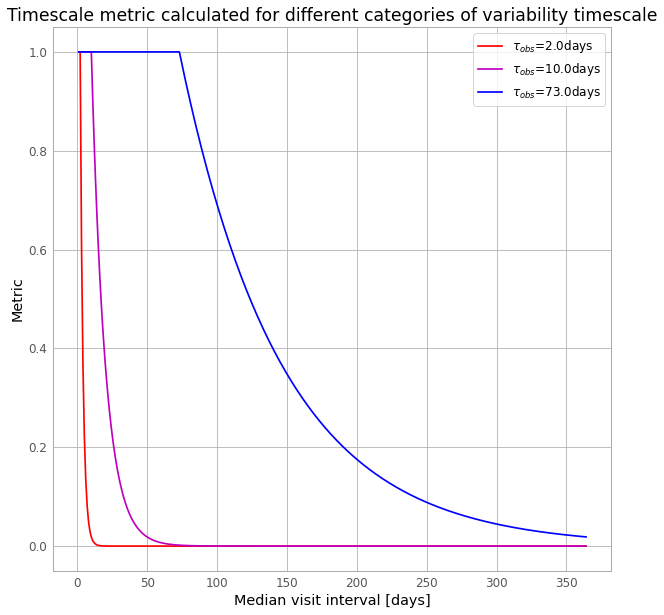

In [8]:
tau_obs_range = [2.0, 10.0, 73.0]
median_visit_intervals = np.array([1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 50.0, 75.0, 100.0, 150.0, 200.0, 365.0])
median_visit_intervals = np.arange(1.0, 365.0, 1.0)
formats = ['r-','m-','b-']

fig,ax = plt.subplots(1, 1, figsize=(10,10))
for i,tau_obs in enumerate(tau_obs_range):
    metric_data = calcVisitIntervalMetric(median_visit_intervals, tau_obs)
    ax.plot(median_visit_intervals, metric_data, formats[i], 
            label='$\\tau_{obs}$='+str(tau_obs)+'days')
ax.set_xlabel('Median visit interval [days]')
ax.set_ylabel('Metric')
ax.set_title('Timescale metric calculated for different categories of variability timescale')
ax.legend()

To evaluate the impact of gaps due to observing seasons, we propose that the season metrics be used as follows.  

The MAF makes the assumption that the maximum possible length of an observing season for a given field is +/-0.5yrs from the time when the field is overhead at the observatory site.  The findSeasonEdges function returns a list of indices of the start and end of each season of observations of a given field under a given observing strategy. 

The gaps between seasons can then be calculated as follows:

In [5]:
def calcSeasonGaps(ra, time):
    """Given the RA of a field pointing, and time of observation, calculate the length of the gaps between 
    observing seasons.
    
    Parameters
    ----------
    ra : float
        The RA (in degrees) of the point on the sky
    time : np.ndarray
        The times of the observations, in MJD
    Returns
    -------
    np.ndarray
        Time gaps in days between sequential observing seasons
    """
    
    seasons = seasonMetrics.calcSeason(ra, time)
    firstOfSeason, lastOfSeason = seasonMetrics.indSeasonEdges(seasons)
    ngaps = len(firstOfSeason)-1
    season_gaps = data[self.mjdCol][lastOfSeason[0:ngaps-1]] - data[self.mjdCol][firstOfSeason[1:ngaps]]
    
    return season_gaps

When evaluating the impact of inter-season gaps, we have to take into account the fact that for most fields, some inter-season gap is inevitable simply due to the annual visibility of a given field from the observatory site.  For variability categories where $\tau_{obs}$ is shorter than the gap in visibility, the season length is not the dominant factor in evaluating a given strategy, and this metric should return 1.0. 

For variability categories where $\tau_{obs}$ is comparable to or longer than the gap in visibility, then the inter-season gap can impact how well sampled the variable's lightcurve is, and long gaps will mean the variables cannot be characterized.  For these categories, we apply the calcVisitIntervalMetric.  

In [12]:
def calcSeasonVisibilityGapsMetric(fieldRA,MJDobservations,tau_obs):
    season_gaps = calcSeasonGaps(fieldRA, MJDobservations)
    
    # To avoid the intensive calculation of the exact visibility of every pointing 
    # for 365d a year, we adopt the pre-calculated values for an example field in 
    # the Galactic Bulge, which receives good, but not circumpolar, annual visibility.  
    total_time_visible_days = 1975.1256 / 24.0
    expected_gap = 365.24 - total_time_visible_days

    if tau_obs >= expected_gap:
        metric = 0.0
        for t in season_gaps:
            metric += calcVisitIntervalMetric(t, tau_obs)
        metric /= 10.0
    
    else:
        metric = 1.0
        
    return metric

### Interpreting the variability time sampling - transients

For transient phenomena, it is relatively straightforward to combine the two metrics to evaluate how well a given strategy will sample the variability.  The number of transients recovered scales linearly with the number of seasons of observation of a given field with a time sampling less than the $\tau_{obs}$ for each category.  

We therefore propose the following metric:

In [13]:
def transientSampleMetric(tau_obs, delta_t, fieldRA, fieldDec, start_date, end_date):
    
    # Stores the metric values for each category:
    metric = []
    
    for tau in tau_obs:
        metric1 = calcVisitIntervalMetric(delta_t, tau_obs)
        metric2 = calcSeasonVisibilityGapsMetric(fieldRA,fieldDec,start_date,end_date,tau)
        
        metric.append( metric1 * metric2 )
    
    return metric

### Interpreting the variability time sampling - periodic variables


Periodic variables can be detected with a wider range of observing strategies, since even low cadence observations (where the cadence exceeds the dominant period) will eventually fully populate the phase curve.  However, there are strong advantages to identifying periodic variables early in the LSST survey, rather than waiting to recover them later.  

Firstly it allows more extensive follow-up and characterization of the variables at an earlier juncture, and (combined with observations later in the survey) ensures that changes in periodicty can also be measured.  Moreover, it allows us to identify those objects which, in addition to periodic behavior, are likely exhibit transitory events such as outbursts, for which additional real-time follow-up observations will be desirable.  It also enables us to distinguish all classes of transient more accurately from the population of repeating variable stars.  

The MAF contains existing metrics to evaluate how well periodic photometric behaviour could be detected from a given set of observations, such as the periodicDetectMetric. We propose that these metrics be calculated for dataSlices containing observations from the first two years of the LSST. 

This metric returns a value of 1 if the periodicity would be detected, or 0 if not.  
We propose that this should be evaluated for the four variability categories of $\tau_{var}$ = {5, 50, 132.5, 365.0} days.